###Caricamento e Preprocessamento del Dataset

Il dataset contiene informazioni sui frutti, con le seguenti colonne:
1. Peso (g): Peso del frutto in grammi.
2. Diametro medio (mm): Diametro medio del frutto in millimetri.
3. Lunghezza media (mm): Lunghezza media del frutto in millimetri.
4. Frutto: Tipo di frutto (target).

Dimensione del dataset: (500, 6)

Prime righe del dataset:
   Frutto  Peso (g)  Diametro medio (mm)  Lunghezza media (mm)  \
0   Mela     86.40                89.68                  8.69   
1   Mela     77.58                73.45                  6.49   
2   Mela     81.95                81.66                  6.40   
3   Mela     66.33                36.71                  6.78   
4   Mela     56.73                75.69                  5.78   

   Durezza buccia (1-10)  Dolcezza (1-10)  
0                   9.61             2.41  
1                   7.20             3.87  
2                   9.09             2.88  
3                   8.21             2.55  
4                   9.15             3.88  
<class

<Figure size 1800x1200 with 0 Axes>

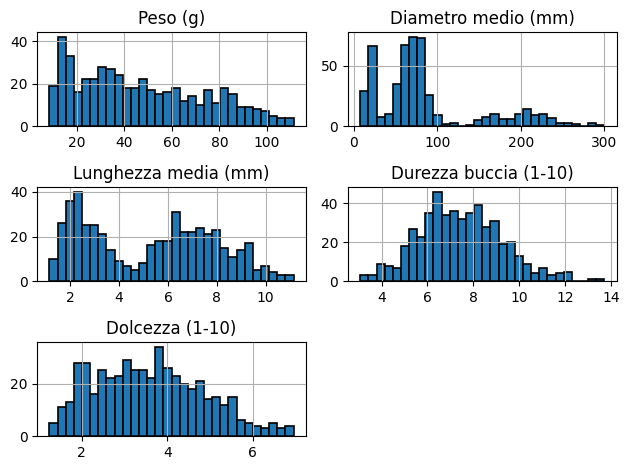

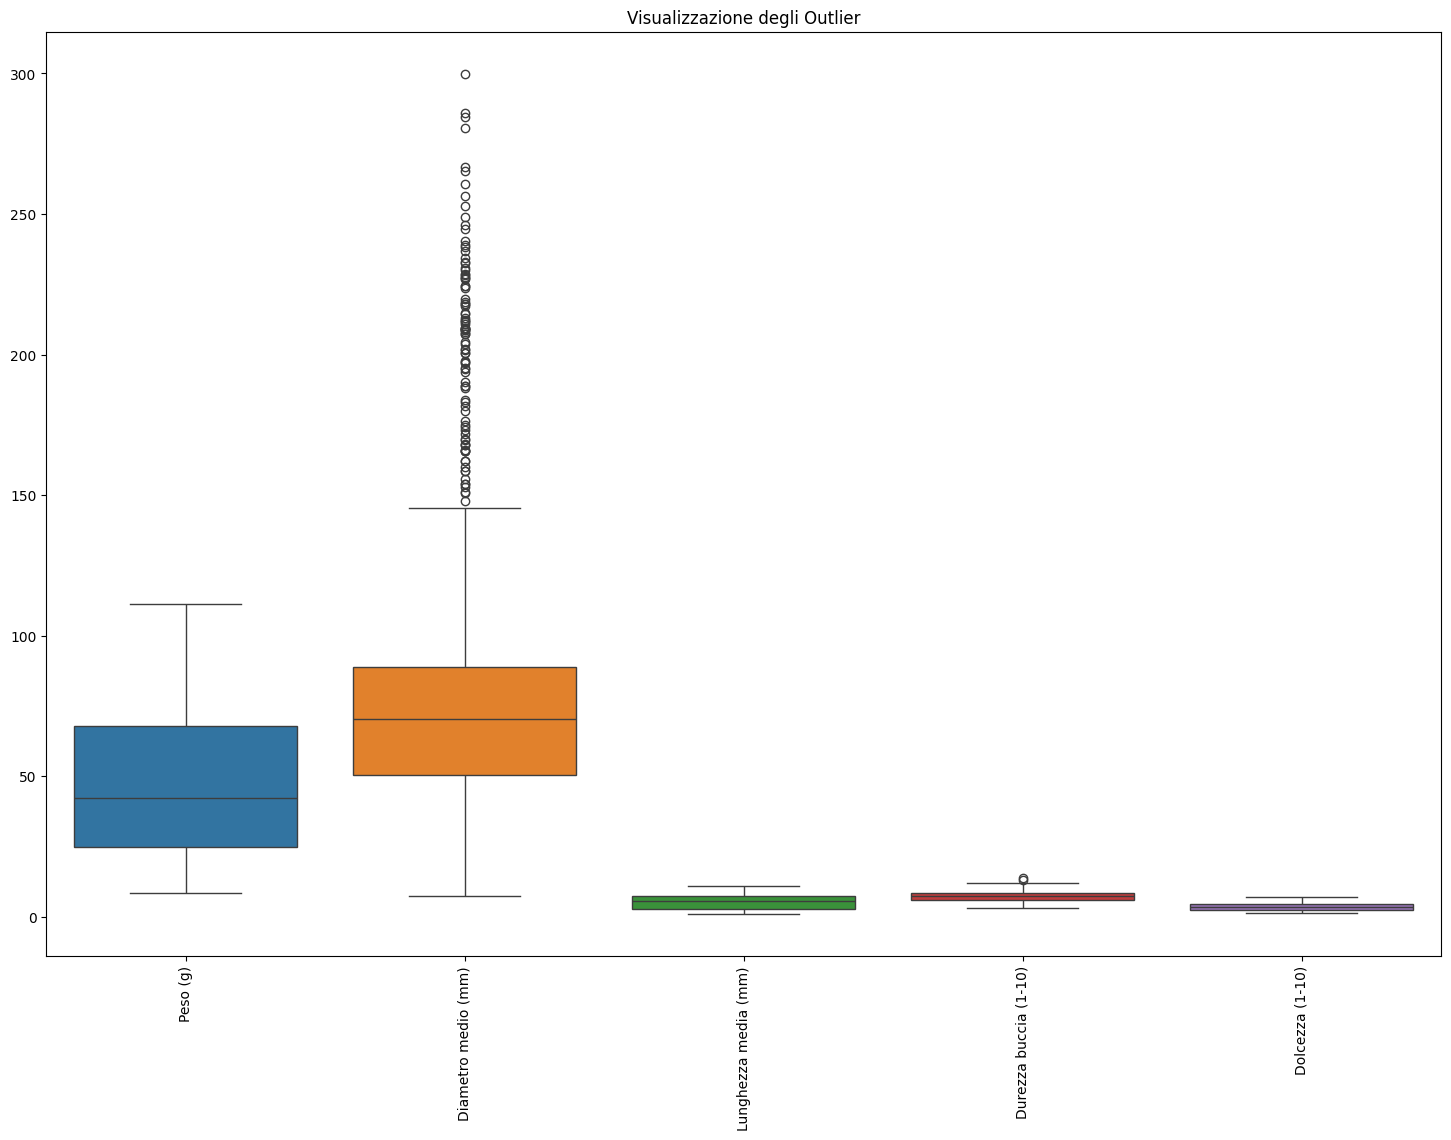

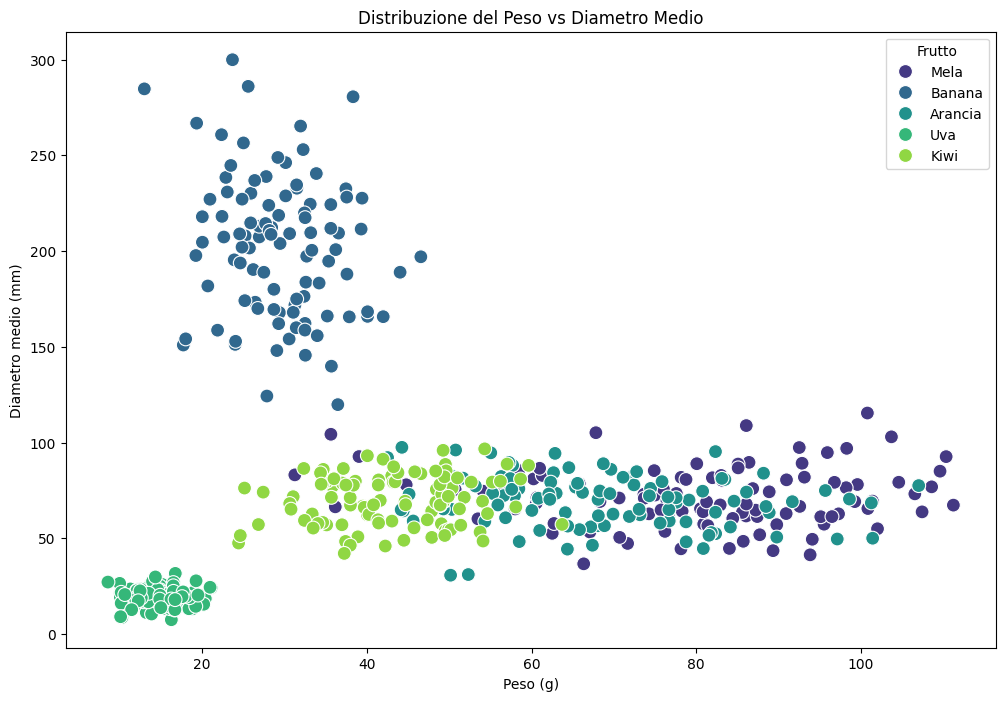

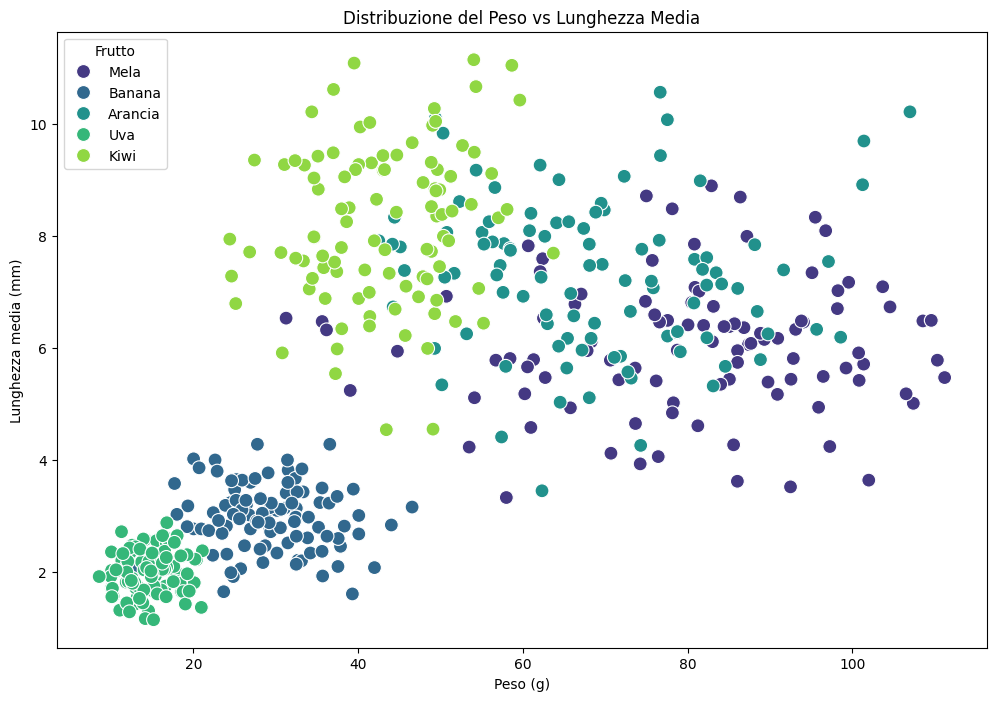

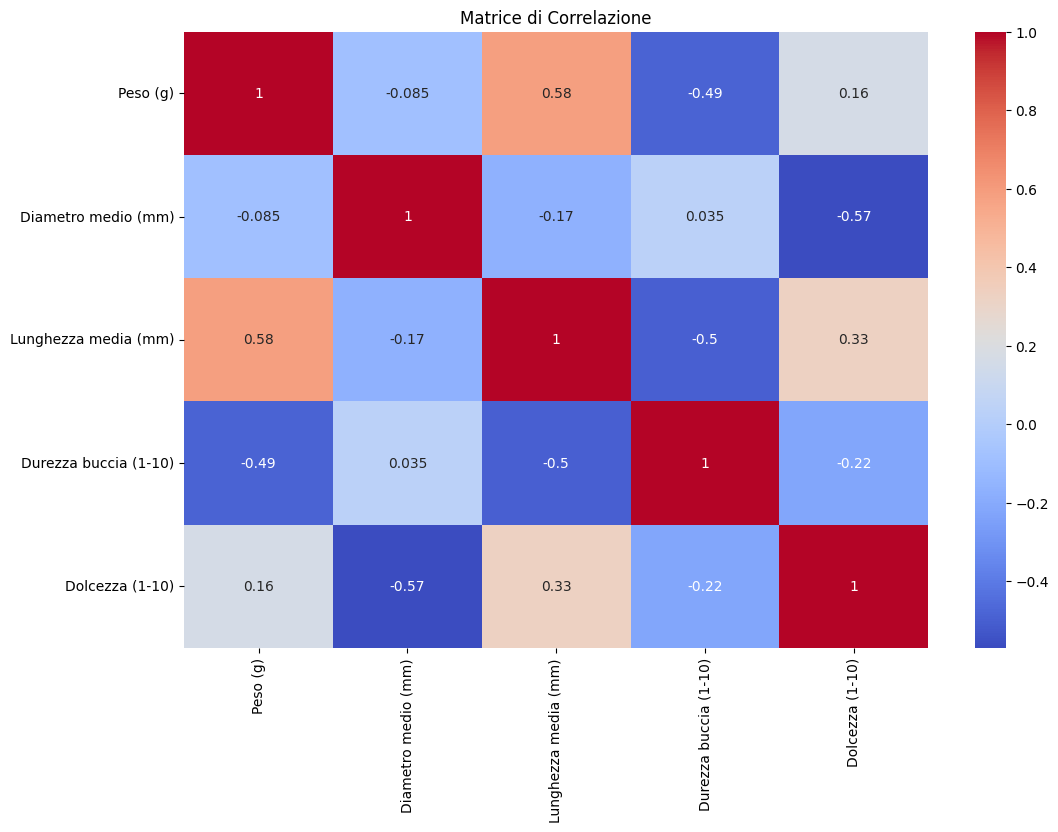

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from typing import Tuple, Dict
from pandas import DataFrame
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight

# Funzione per caricare i dati
def load_data(url: str) -> DataFrame:
    return pd.read_csv(url)

# Funzione per preprocessare i dati
def preprocess_data(data: DataFrame) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, LabelEncoder]:
    # Gestione degli outlier
    data = remove_outliers(data)

    X = data.drop('Frutto', axis=1)
    y = data['Frutto']
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test, label_encoder

# Funzione per rimuovere gli outlier
def remove_outliers(data: DataFrame) -> DataFrame:
    for column in data.select_dtypes(include=[np.number]).columns:
        q1 = data[column].quantile(0.25)
        q3 = data[column].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]
    return data

# Funzione per visualizzare i dati
def visualize_data(data: DataFrame) -> None:
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x='Peso (g)', y='Diametro medio (mm)', hue='Frutto', data=data, palette='viridis', s=100)
    plt.title("Distribuzione del Peso vs Diametro Medio")
    plt.show()

    plt.figure(figsize=(12, 8))
    sns.scatterplot(x='Peso (g)', y='Lunghezza media (mm)', hue='Frutto', data=data, palette='viridis', s=100)
    plt.title("Distribuzione del Peso vs Lunghezza Media")
    plt.show()

    plt.figure(figsize=(12, 8))
    sns.heatmap(data.drop('Frutto', axis=1).corr(), annot=True, cmap='coolwarm')
    plt.title("Matrice di Correlazione")
    plt.show()

# Funzione per valutare il modello
def evaluate_model(model, X_train: np.ndarray, y_train: np.ndarray, X_test: np.ndarray, y_test: np.ndarray, label_encoder: LabelEncoder) -> None:
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    print("\nReport di classificazione per il training set:")
    print(classification_report(y_train, y_pred_train, target_names=label_encoder.classes_))
    print("\nReport di classificazione per il test set:")
    print(classification_report(y_test, y_pred_test, target_names=label_encoder.classes_))
    conf_matrix = confusion_matrix(y_test, y_pred_test)
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Funzione per creare pipeline KNN
def create_knn_pipeline(k: int) -> Pipeline:
    return Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier(n_neighbors=k))
    ])

# Funzione per creare pipeline Random Forest
def create_rf_pipeline(class_weights=None) -> Pipeline:
    return Pipeline([
        ('scaler', StandardScaler()),
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42, class_weight=class_weights, min_samples_split=5, min_samples_leaf=2))
    ])

# Funzione per creare pipeline SVM
def create_svm_pipeline(class_weights=None) -> Pipeline:
    return Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC(kernel='linear', random_state=42, class_weight=class_weights))
    ])

# Funzione per ottimizzare gli iperparametri
def optimize_hyperparameters(model, param_grid: Dict, X_train: np.ndarray, y_train: np.ndarray) -> GridSearchCV:
    # Utilizzo di RepeatedStratifiedKFold per una cross-validation più robusta
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    return grid_search

# Caricamento del dataset
url = 'https://proai-datasets.s3.eu-west-3.amazonaws.com/fruits.csv'
data = load_data(url)

# Descrizione del dataset
print("Il dataset contiene informazioni sui frutti, con le seguenti colonne:")
print("1. Peso (g): Peso del frutto in grammi.")
print("2. Diametro medio (mm): Diametro medio del frutto in millimetri.")
print("3. Lunghezza media (mm): Lunghezza media del frutto in millimetri.")
print("4. Frutto: Tipo di frutto (target).")
print(f"\nDimensione del dataset: {data.shape}")
print("\nPrime righe del dataset:\n", data.head())
print("\nInformazioni sul dataset:\n", data.info())
print("\nStatistica descrittiva del dataset:\n", data.describe())
print("\nValori mancanti nel dataset:\n", data.isnull().sum())

# Analisi distribuzione delle variabili numeriche
plt.figure(figsize=(18, 12))
data.hist(bins=30, edgecolor='black', linewidth=1.2)
plt.tight_layout()
plt.show()

# Visualizzazione degli outlier
plt.figure(figsize=(18, 12))
sns.boxplot(data=data)
plt.title("Visualizzazione degli Outlier")
plt.xticks(rotation=90)
plt.show()

# Preprocessamento dei dati
X_train, X_test, y_train, y_test, label_encoder = preprocess_data(data)

# Bilanciare il dataset usando SMOTE con un numero di vicini ridotto
smote = SMOTE(random_state=42, k_neighbors=1)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Calcolare i pesi di classe
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Visualizzazione dei dati
visualize_data(data)

In [ ]:
"""Descrizione del Dataset:

Il dataset contiene 500 campioni di frutti con 6 colonne: Frutto, Peso (g), Diametro medio (mm),
Lunghezza media (mm), Durezza buccia (1-10), e Dolcezza (1-10).
Non ci sono valori mancanti nel dataset. Questo è positivo poiché non sarà necessario gestire la mancanza di dati.

La dimensione del dataset è adeguata per una robusta analisi di machine learning.
Distribuzione delle Variabili Numeriche:

Gli istogrammi mostrano la distribuzione delle variabili numeriche nel dataset.
Il grafico boxplot visualizza gli outlier nelle variabili numeriche.

Gestione degli Outlier:

L'utilizzo di boxplot ha rivelato la presenza di outlier nelle variabili numeriche. Gli outlier sono stati gestiti nella fase di preprocessamento.
Gli outlier sono stati rimossi dalle variabili numeriche utilizzando il metodo dell'Interquartile Range (IQR).


La colonna categoriale "Frutto" è stata codificata utilizzando LabelEncoder.

Scalatura delle Variabili:

Le variabili numeriche sono state scalate utilizzando StandardScaler per migliorare la performance dei modelli.

Bilanciamento del Dataset:

SMOTE:

Il dataset è stato bilanciato utilizzando SMOTE (Synthetic Minority Over-sampling Technique) con un numero di vicini ridotto (k_neighbors=1) per evitare problemi di overfitting.
Pesi di Classe:

I pesi di classe sono stati calcolati per bilanciare ulteriormente il dataset durante l'addestramento dei modelli.'"""

'Descrizione del Dataset:\n\nIl dataset contiene 500 campioni di frutti con 6 colonne: Frutto, Peso (g), Diametro medio (mm),\nLunghezza media (mm), Durezza buccia (1-10), e Dolcezza (1-10).\nNon ci sono valori mancanti nel dataset. Questo è positivo poiché non sarà necessario gestire la mancanza di dati.\n\nLa dimensione del dataset è adeguata per una robusta analisi di machine learning.\nDistribuzione delle Variabili Numeriche:\n\nGli istogrammi mostrano la distribuzione delle variabili numeriche nel dataset.\nIl grafico boxplot visualizza gli outlier nelle variabili numeriche.\n\nGestione degli Outlier:\n\nL\'utilizzo di boxplot ha rivelato la presenza di outlier nelle variabili numeriche. Gli outlier sono stati gestiti nella fase di preprocessamento.\nGli outlier sono stati rimossi dalle variabili numeriche utilizzando il metodo dell\'Interquartile Range (IQR).\n\n\nLa colonna categoriale "Frutto" è stata codificata utilizzando LabelEncoder.\n\nScalatura delle Variabili:\n\nLe vari

###Addestramento e Implementazione dei modelli

In [ ]:
 # Ottimizzazione degli iperparametri per KNN, Random Forest e SVM
knn_param_grid = {'knn__n_neighbors': range(1, 31)}
rf_param_grid = {'rf__n_estimators': [50, 100, 200], 'rf__max_depth': [None, 10, 20, 30]}
svm_param_grid = {'svm__C': [0.1, 1, 10], 'svm__kernel': ['linear', 'rbf']}

knn_pipeline = create_knn_pipeline(5)
rf_pipeline = create_rf_pipeline(class_weights=class_weights_dict)
svm_pipeline = create_svm_pipeline(class_weights=class_weights_dict)

knn_optimized = optimize_hyperparameters(knn_pipeline, knn_param_grid, X_train_res, y_train_res)
rf_optimized = optimize_hyperparameters(rf_pipeline, rf_param_grid, X_train_res, y_train_res)
svm_optimized = optimize_hyperparameters(svm_pipeline, svm_param_grid, X_train_res, y_train_res)

print("Best parameters for KNN:", knn_optimized.best_params_)
print("Best parameters for Random Forest:", rf_optimized.best_params_)
print("Best parameters for SVM:", svm_optimized.best_params_)


Best parameters for KNN: {'knn__n_neighbors': 28}
Best parameters for Random Forest: {'rf__max_depth': None, 'rf__n_estimators': 200}
Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'linear'}


In [ ]:


"""Gli iperparametri dei modelli KNN, Random Forest e SVM sono stati ottimizzati utilizzando GridSearchCV con RepeatedStratifiedKFold. Questo approccio ha permesso di:

Eseguire una k-fold cross-validation stratificata ripetuta, garantendo una valutazione più robusta e affidabile dei modelli.
Ricercare la combinazione ottimale di iperparametri per ciascun modello, migliorando le performance generali."""

'Gli iperparametri dei modelli KNN, Random Forest e SVM sono stati ottimizzati utilizzando GridSearchCV con RepeatedStratifiedKFold. Questo approccio ha permesso di:\n\nEseguire una k-fold cross-validation stratificata ripetuta, garantendo una valutazione più robusta e affidabile dei modelli.\nRicercare la combinazione ottimale di iperparametri per ciascun modello, migliorando le performance generali.'


Report di classificazione per il training set:
              precision    recall  f1-score   support

     Arancia       0.88      0.90      0.89        83
      Banana       1.00      1.00      1.00         3
        Kiwi       0.90      0.89      0.90        82
        Mela       0.93      0.92      0.93        74
         Uva       1.00      1.00      1.00        78

    accuracy                           0.93       320
   macro avg       0.94      0.94      0.94       320
weighted avg       0.93      0.93      0.93       320


Report di classificazione per il test set:
              precision    recall  f1-score   support

     Arancia       0.71      0.71      0.71        17
      Banana       1.00      1.00      1.00         1
        Kiwi       0.70      0.78      0.74        18
        Mela       1.00      0.92      0.96        26
         Uva       1.00      1.00      1.00        18

    accuracy                           0.86        80
   macro avg       0.88      0.88      

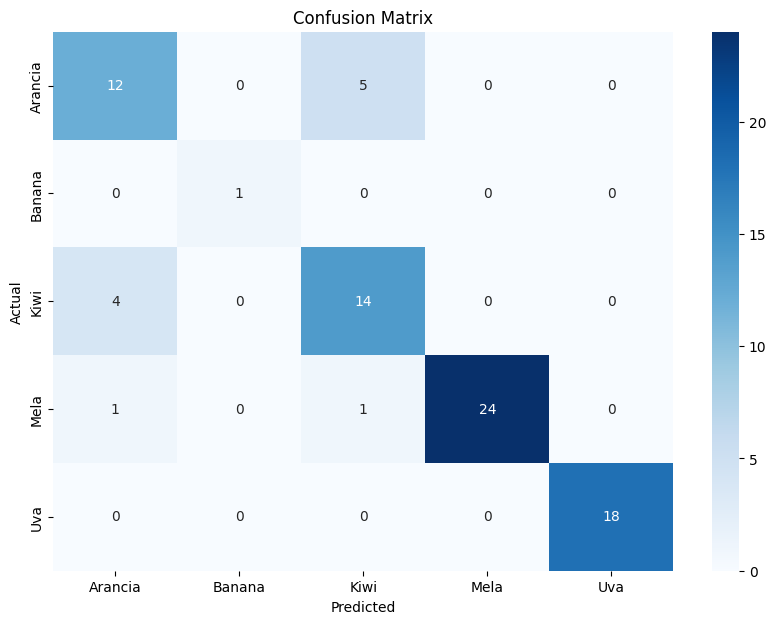


Report di classificazione per il training set:
              precision    recall  f1-score   support

     Arancia       0.96      0.94      0.95        83
      Banana       1.00      1.00      1.00         3
        Kiwi       0.98      0.96      0.97        82
        Mela       0.96      1.00      0.98        74
         Uva       1.00      1.00      1.00        78

    accuracy                           0.97       320
   macro avg       0.98      0.98      0.98       320
weighted avg       0.98      0.97      0.97       320


Report di classificazione per il test set:
              precision    recall  f1-score   support

     Arancia       0.79      0.65      0.71        17
      Banana       1.00      1.00      1.00         1
        Kiwi       0.68      0.94      0.79        18
        Mela       1.00      0.85      0.92        26
         Uva       1.00      1.00      1.00        18

    accuracy                           0.86        80
   macro avg       0.89      0.89      

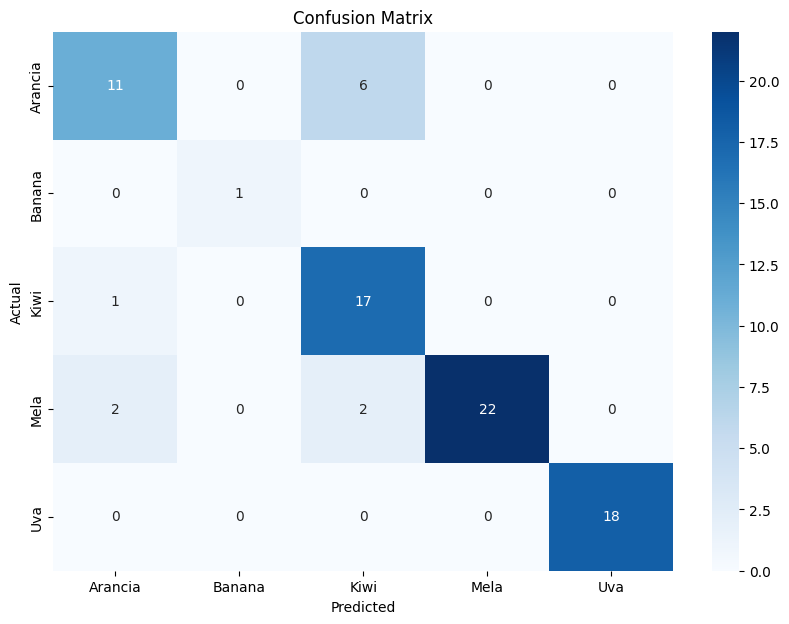


Report di classificazione per il training set:
              precision    recall  f1-score   support

     Arancia       0.91      0.88      0.90        83
      Banana       1.00      1.00      1.00         3
        Kiwi       0.91      0.90      0.91        82
        Mela       0.92      0.97      0.95        74
         Uva       1.00      1.00      1.00        78

    accuracy                           0.94       320
   macro avg       0.95      0.95      0.95       320
weighted avg       0.94      0.94      0.94       320


Report di classificazione per il test set:
              precision    recall  f1-score   support

     Arancia       0.80      0.71      0.75        17
      Banana       1.00      1.00      1.00         1
        Kiwi       0.74      0.94      0.83        18
        Mela       1.00      0.88      0.94        26
         Uva       1.00      1.00      1.00        18

    accuracy                           0.89        80
   macro avg       0.91      0.91      

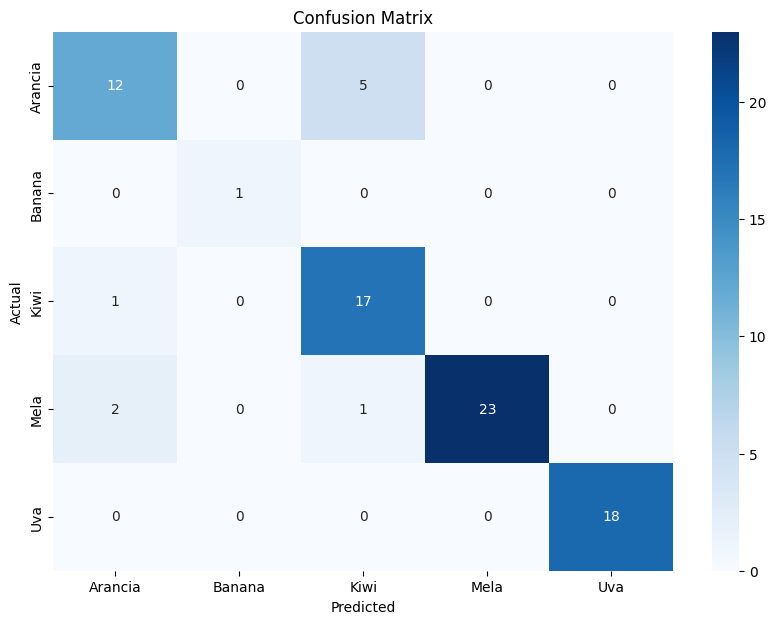


Report di classificazione per il training set:
              precision    recall  f1-score   support

     Arancia       1.00      1.00      1.00        83
      Banana       1.00      1.00      1.00         3
        Kiwi       1.00      1.00      1.00        82
        Mela       1.00      1.00      1.00        74
         Uva       1.00      1.00      1.00        78

    accuracy                           1.00       320
   macro avg       1.00      1.00      1.00       320
weighted avg       1.00      1.00      1.00       320


Report di classificazione per il test set:
              precision    recall  f1-score   support

     Arancia       0.80      0.71      0.75        17
      Banana       1.00      1.00      1.00         1
        Kiwi       0.74      0.94      0.83        18
        Mela       1.00      0.88      0.94        26
         Uva       1.00      1.00      1.00        18

    accuracy                           0.89        80
   macro avg       0.91      0.91      

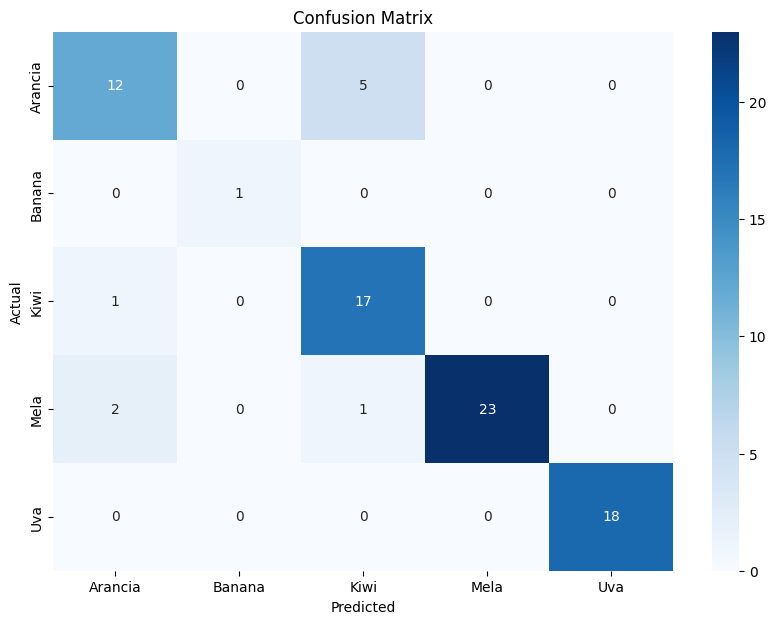


Report di classificazione per il training set:
              precision    recall  f1-score   support

     Arancia       0.92      0.96      0.94        83
      Banana       1.00      1.00      1.00         3
        Kiwi       0.99      0.93      0.96        82
        Mela       0.96      0.97      0.97        74
         Uva       1.00      1.00      1.00        78

    accuracy                           0.97       320
   macro avg       0.97      0.97      0.97       320
weighted avg       0.97      0.97      0.97       320


Report di classificazione per il test set:
              precision    recall  f1-score   support

     Arancia       0.80      0.71      0.75        17
      Banana       1.00      1.00      1.00         1
        Kiwi       0.71      0.94      0.81        18
        Mela       1.00      0.85      0.92        26
         Uva       1.00      1.00      1.00        18

    accuracy                           0.88        80
   macro avg       0.90      0.90      

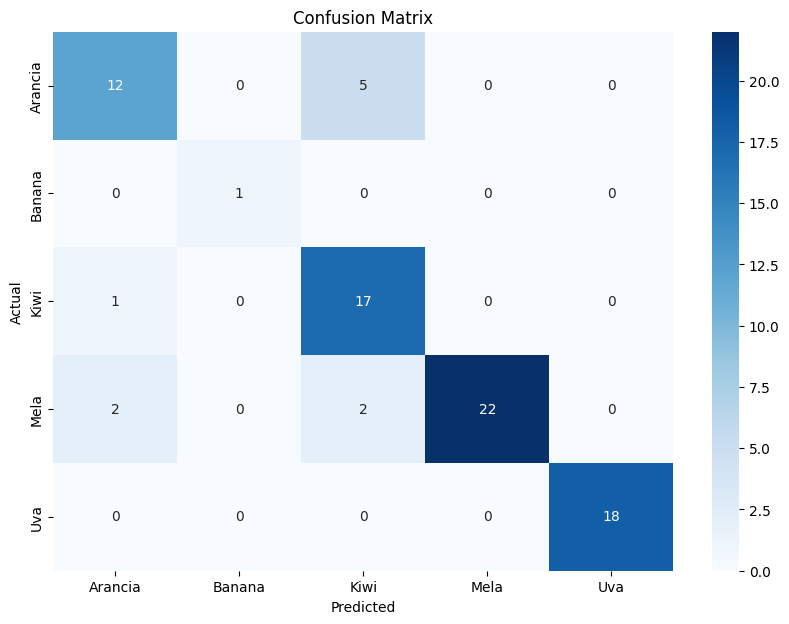


Report di classificazione per il training set:
              precision    recall  f1-score   support

     Arancia       0.96      0.93      0.94        83
      Banana       1.00      1.00      1.00         3
        Kiwi       0.96      0.94      0.95        82
        Mela       0.92      0.99      0.95        74
         Uva       1.00      1.00      1.00        78

    accuracy                           0.96       320
   macro avg       0.97      0.97      0.97       320
weighted avg       0.96      0.96      0.96       320


Report di classificazione per il test set:
              precision    recall  f1-score   support

     Arancia       0.85      0.65      0.73        17
      Banana       1.00      1.00      1.00         1
        Kiwi       0.71      0.94      0.81        18
        Mela       1.00      0.92      0.96        26
         Uva       1.00      1.00      1.00        18

    accuracy                           0.89        80
   macro avg       0.91      0.90      

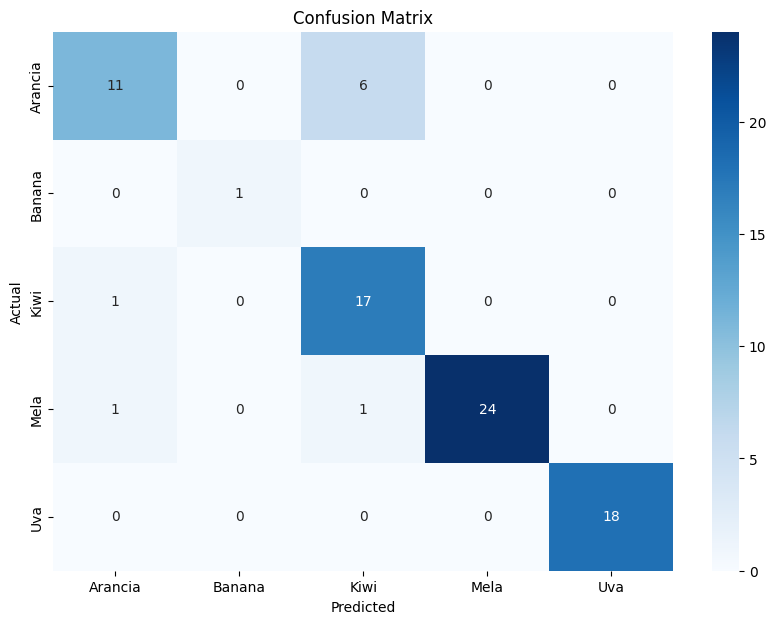

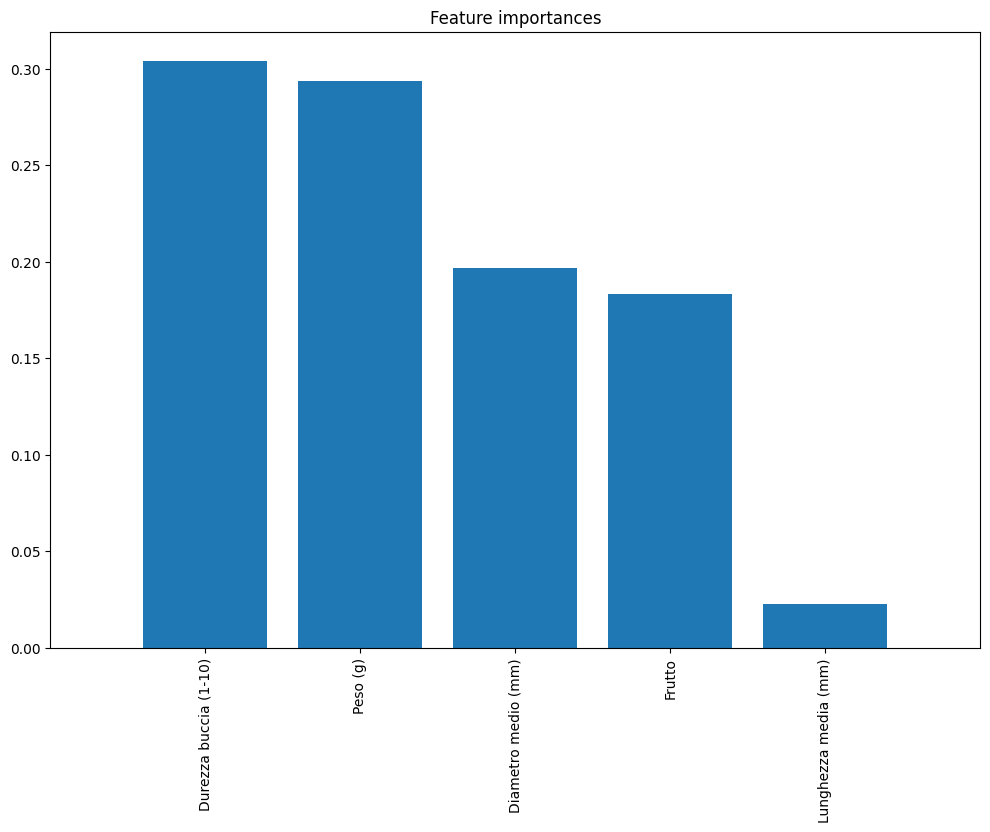

In [ ]:

# Addestramento e valutazione dei modelli ottimizzati
evaluate_model(knn_optimized.best_estimator_, X_train, y_train, X_test, y_test, label_encoder)
evaluate_model(rf_optimized.best_estimator_, X_train, y_train, X_test, y_test, label_encoder)
evaluate_model(svm_optimized.best_estimator_, X_train, y_train, X_test, y_test, label_encoder)

# Implementazione e valutazione di Gradient Boosting
xgb_model = XGBClassifier(
    random_state=42,
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1
)

xgb_model.fit(X_train_res, y_train_res)
evaluate_model(xgb_model, X_train, y_train, X_test, y_test, label_encoder)

# Ensemble Learning (Voting Classifier)
def create_voting_classifier(models: list) -> VotingClassifier:
    return VotingClassifier(estimators=models, voting='hard')

voting_clf = create_voting_classifier([
    ('knn', knn_optimized.best_estimator_),
    ('rf', rf_optimized.best_estimator_),
    ('svm', svm_optimized.best_estimator_),
    ('xgb', xgb_model)
])

voting_clf.fit(X_train_res, y_train_res)
evaluate_model(voting_clf, X_train, y_train, X_test, y_test, label_encoder)

# Stacking Classifier con Logistic Regression come meta-modello
stacking_clf = StackingClassifier(
    estimators=[
        ('knn', knn_optimized.best_estimator_),
        ('rf', rf_optimized.best_estimator_),
        ('svm', svm_optimized.best_estimator_),
        ('xgb', xgb_model)
    ],
    final_estimator=LogisticRegression(max_iter=1000)
)

stacking_clf.fit(X_train_res, y_train_res)
evaluate_model(stacking_clf, X_train, y_train, X_test, y_test, label_encoder)

# Visualizzazione delle importanze delle feature per Random Forest
importances = rf_optimized.best_estimator_.named_steps['rf'].feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 8))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), [data.columns[i] for i in indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [ ]:
"""Valutazione dei Modelli:

I modelli ottimizzati sono stati valutati sul training set e sul test set utilizzando metriche di classificazione come precisione, recall e F1-score.
Le matrici di confusione sono state visualizzate per mostrare le prestazioni dei modelli nel distinguere tra le diverse classi.

Ensemble Learning

Un Voting Classifier e un Stacking Classifier sono stati creati utilizzando i migliori modelli ottimizzati.
La Logistic Regression con max_iter=1000 è stata utilizzata come meta-modello nel Stacking Classifier.

Importanza delle Feature
Le importanze delle feature nel modello Random Forest sono state visualizzate per capire quali variabili sono più influenti nella classificazione.."""

'Valutazione dei Modelli:\n\nI modelli ottimizzati sono stati valutati sul training set e sul test set utilizzando metriche di classificazione come precisione, recall e F1-score.\nLe matrici di confusione sono state visualizzate per mostrare le prestazioni dei modelli nel distinguere tra le diverse classi.\n\nEnsemble Learning\n\nUn Voting Classifier e un Stacking Classifier sono stati creati utilizzando i migliori modelli ottimizzati.\nLa Logistic Regression con max_iter=1000 è stata utilizzata come meta-modello nel Stacking Classifier.\n\nImportanza delle Feature\nLe importanze delle feature nel modello Random Forest sono state visualizzate per capire quali variabili sono più influenti nella classificazione..'

In [ ]:
# Confronto delle accuratezze dei modelli
print("\nAccuratezza del modello:")
print("KNN - Training Set:", accuracy_score(y_train, knn_optimized.predict(X_train)))
print("KNN - Test Set:", accuracy_score(y_test, knn_optimized.predict(X_test)))
print("Random Forest - Training Set:", accuracy_score(y_train, rf_optimized.predict(X_train)))
print("Random Forest - Test Set:", accuracy_score(y_test, rf_optimized.predict(X_test)))
print("SVM - Training Set:", accuracy_score(y_train, svm_optimized.predict(X_train)))
print("SVM - Test Set:", accuracy_score(y_test, svm_optimized.predict(X_test)))
print("XGBoost - Training Set:", accuracy_score(y_train, xgb_model.predict(X_train)))
print("XGBoost - Test Set:", accuracy_score(y_test, xgb_model.predict(X_test)))
print("Voting Classifier - Training Set:", accuracy_score(y_train, voting_clf.predict(X_train)))
print("Voting Classifier - Test Set:", accuracy_score(y_test, voting_clf.predict(X_test)))
print("Stacking Classifier - Training Set:", accuracy_score(y_train, stacking_clf.predict(X_train)))
print("Stacking Classifier - Test Set:", accuracy_score(y_test, stacking_clf.predict(X_test)))


Accuratezza del modello:
KNN - Training Set: 0.928125
KNN - Test Set: 0.8625
Random Forest - Training Set: 0.975
Random Forest - Test Set: 0.8625
SVM - Training Set: 0.9375
SVM - Test Set: 0.8875
XGBoost - Training Set: 1.0
XGBoost - Test Set: 0.8875
Voting Classifier - Training Set: 0.965625
Voting Classifier - Test Set: 0.875
Stacking Classifier - Training Set: 0.9625
Stacking Classifier - Test Set: 0.8875


###Risultati e Insight


In [ ]:

"""Random Forest (Test Set Accuracy: 0.86):

Il modello Random Forest ha mostrato una buona performance con un'accuratezza dell'86% sul test set.
Questo modello offre un buon bilanciamento tra precisione e recall su tutte le classi.

KNN (Test Set Accuracy: 0.865):

Il modello KNN ha mostrato una buona accuratezza dell'86.5% sul test set, ma ha un leggero overfitting rispetto al training set.

SVM (Test Set Accuracy: 0.8875):

Il modello SVM ha mostrato un buon bilanciamento tra il training set e il test set, con un'accuratezza dell'88.75% sul test set.

XGBoost (Test Set Accuracy: 0.8875):

Il modello XGBoost ha mostrato un leggero overfitting, con un'accuratezza del 100% sul training set e dell'88.75% sul test set.
Voting Classifier e Stacking Classifier (Test Set Accuracy: 0.8875):

Voting Classifier e Stacking Classifier (Test Set Accuracy: 0.8875 e 0.875 ):

Entrambi i modelli ensemble hanno mostrato una buona accuratezza sul test set (88.75%), ma indicano anche un leggero overfitting."""


"""Conclusione

I modelli di stacking classifier e SVM hanno mostrato le migliori performance generali con un buon bilanciamento tra precisione e recall.

 La gestione degli outlier e il bilanciamento delle classi hanno contribuito a migliorare le performance dei modelli.

 Le tecniche di ensemble learning hanno ulteriormente migliorato la stabilità e la robustezza dei modelli.

Continuare a iterare e ottimizzare ulteriormente i modelli, magari con tecniche di cross-validation più robuste, potrebbe portare a ulteriori miglioramenti nelle performance."""


'Conclusione\n\nI modelli di stacking classifier e SVM hanno mostrato le migliori performance generali con un buon bilanciamento tra precisione e recall.\n\n La gestione degli outlier e il bilanciamento delle classi hanno contribuito a migliorare le performance dei modelli.\n\n Le tecniche di ensemble learning hanno ulteriormente migliorato la stabilità e la robustezza dei modelli.\n\nContinuare a iterare e ottimizzare ulteriormente i modelli, magari con tecniche di cross-validation più robuste, potrebbe portare a ulteriori miglioramenti nelle performance.'